In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
# Input data files are available in the read-only "../input/" directory


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

Using TensorFlow backend.


In [3]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
import nltk 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
# Use English stemmer.
word_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [4]:
from gensim.models.keyedvectors import KeyedVectors

In [5]:
real_news= pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake_news= pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

**Remove missing text rows from the data whose length is less than 3 characters (cells with only white spaces for ex.) and also rows with NAN**

In [6]:
real_news['text'] = real_news['title'] + " " + real_news['text'] + " " + real_news['subject']
fake_news['text'] = fake_news['title'] + " " + fake_news['text'] + " " + real_news['subject']

In [7]:
print(real_news.shape)
print(fake_news.shape)
real_news = real_news[real_news['text'].str.len() >= 3]
fake_news = fake_news[fake_news['text'].str.len() >=3]
real_news['label'] = 1
fake_news['label'] = 0
print(real_news.shape)
print(fake_news.shape)

(21417, 4)
(23481, 4)
(21417, 5)
(21417, 5)


Data Cleaning 

In [8]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
def get_cleaned_data(input_data, mode='df'):
    stop = stopwords.words('english')
    
    input_df = ''
    
    if mode != 'df':
        input_df = pd.DataFrame([input_data], columns=['text'])
    else:
        input_df = input_data
        
    #lowercase the text
    input_df['text'] = input_df['text'].str.lower()
    
    input_df['text'] = input_df['text'].apply(lambda elem: decontracted(elem))
    
    #remove special characters
    input_df['text'] = input_df['text'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    
    # remove numbers
    input_df['text'] = input_df['text'].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    #remove stopwords
    input_df['text'] = input_df['text'].apply(lambda x: ' '.join([word.strip() for word in x.split() if word not in (stop)]))
    
    #stemming, changes the word to root form
#     input_df['text'] = input_df['text'].apply(lambda words: [word_stemmer.stem(word) for word in words])
    
    #lemmatization, same as stemmer, but language corpus is used to fetch the root form, so resulting words make sense
#     more description @ https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
    input_df['text'] = input_df['text'].apply(lambda words: (wordnet_lemmatizer.lemmatize(words)))
#     print(input_df.head(3))
    
    return input_df

In [10]:
fake_news = get_cleaned_data(fake_news)

In [11]:
real_news = get_cleaned_data(real_news)

In [12]:
news_data = pd.concat([real_news, fake_news], ignore_index = True)
print(news_data.shape)

(42834, 5)


In [13]:
news_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",us budget fight looms republicans flip fiscal ...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,us military accept transgender recruits monday...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior us republican senator let mr mueller jo...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped australian diplomat ti...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service charge amuch amazon...,politicsNews,"December 29, 2017",1


In [14]:
news_data.to_csv("news_data_with_labels.csv")

In [15]:
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.3

In [16]:
x_train,x_test,y_train,y_test = train_test_split(news_data.text,news_data.label,random_state = 42, test_size=VALIDATION_SPLIT, shuffle=True)

Vectorize the text samples into a 2D integer tensor

In [17]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

# Updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." 
# It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 
# So lower integer means more frequent word (often the first few are stop words because they appear a lot).
tokenizer.fit_on_texts(x_train)

# Transforms each text in texts to a sequence of integers. 
# So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
# sequences = tokenizer.texts_to_sequences(news_data_df.text)
tokenized_train = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(tokenized_train, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found {} unique tokens. and {} lines '.format(len(word_index), len(X_train)))

Found 162410 unique tokens. and 29983 lines 


In [18]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=MAX_SEQUENCE_LENGTH)

Fetch pre-trained embedding index from GoogleNews-vectors-negative300:
* GoogleNews vectors are in most to least frequent order, so the first N are usually the N-sized subset. 
* So use limit=500000 to get the most-frequent 500,000 words' vectors – saving 5/6ths of the memory/load-time.

In [19]:
def get_embeddings(path):
  # model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300', binary=True, limit=500000)
  wv_from_bin = KeyedVectors.load_word2vec_format(path, binary=True, limit=500000) 
  #extracting word vectors from google news vector
  embeddings_index = {}
  for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
      coefs = np.asarray(vector, dtype='float32')
      embeddings_index[word] = coefs
  
  return embeddings_index

In [20]:
embeddings_index = {}
embeddings_index = get_embeddings('/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin')
print('Found %s word vectors.' % len(embeddings_index))

Found 500000 word vectors.


Preparing embedding matrix.

In [21]:
# # prepare embedding matrix format - 1
# num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
# embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
# for word, i in word_index.items():
#     if i >= MAX_NUM_WORDS:
#         continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

In [22]:
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

Free up the memory

In [23]:
del embeddings_index

Verify if the dataframe has real vs fact values, real news has real_fact = 1 and fake news has real_fact = 0

In [24]:
news_data[news_data['label'] == 0]

,title,text,subject,date,label
21417,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends embarrassing new years eve ...,News,"December 31, 2017",0
21418,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian c...,News,"December 31, 2017",0
21419,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes internet joke thr...,News,"December 30, 2017",0
21420,Trump Is So Obsessed He Even Has Obama’s Name...,trump obsessed even obamas name coded website ...,News,"December 29, 2017",0
21421,Pope Francis Just Called Out Donald Trump Dur...,pope francis called donald trump christmas spe...,News,"December 25, 2017",0
...,...,...,...,...,...
42829,SHOCKING TAXPAYER TAB FOR OBAMA’S GOLF Trips A...,shocking taxpayer tab obamas golf trips fundra...,left-news,"Oct 16, 2015",0
42830,WOW! WORLD’S TOP PHYSICIST AND DEMOCRAT: Obama...,wow worlds top physicist democrat obama backs ...,left-news,"Oct 15, 2015",0
42831,URGENT! Join #AntiHillaryFlashMob Rally Agains...,urgent join antihillaryflashmob rally hillary ...,left-news,"Oct 14, 2015",0
42832,IS LAW AND ORDER SVU PANDERING To Cop Hating M...,law order svu pandering cop hating millennials...,left-news,"Oct 14, 2015",0


In [25]:
news_data[news_data['label'] == 1]

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",us budget fight looms republicans flip fiscal ...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,us military accept transgender recruits monday...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior us republican senator let mr mueller jo...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped australian diplomat ti...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service charge amuch amazon...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,fully committed nato backs new us approach afg...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,lexisnexis withdrew two products chinese marke...,worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,minsk cultural hub becomes authorities minsk r...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,vatican upbeat possibility pope francis visiti...,worldnews,"August 22, 2017",1


**Prepare the CNN model with GlobalMaxPooling for classification**

In [26]:
def cnn_net1():
    model = Sequential()

    #Non-trainable embeddidng layer
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(units = 250 , activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

**Prepare the CNN model with Deep network for classification**

In [27]:
def cnn_net2():
    model = Sequential()

    #Non-trainable embeddidng layer
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(4))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(4))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(4))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [28]:
def get_pred_output(text_to_check):
    sequences = tokenizer.texts_to_sequences([text_to_check])
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    predicted_val = model.predict_classes(data)
#     predicted_val = model.predict(data)    
#     if predicted_val.max() > 0.7:
#         output = 1
#     else:
#         output = 0
    return predicted_val
    

In [29]:
# train a 1D convnet with global maxpooling
model = cnn_net1()

batch_size = 256
epochs = 8

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          48723300  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 497, 128)          153728    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               32250     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [30]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Train on 29983 samples, validate on 12851 samples
Epoch 1/8
29983/29983 [==============================] - 167s 6ms/step - loss: 0.2010 - accuracy: 0.9093 - val_loss: 0.0182 - val_accuracy: 0.9933
Epoch 2/8
29983/29983 [==============================] - 167s 6ms/step - loss: 0.0282 - accuracy: 0.9902 - val_loss: 0.0167 - val_accuracy: 0.9943
Epoch 3/8
29983/29983 [==============================] - 167s 6ms/step - loss: 0.0179 - accuracy: 0.9939 - val_loss: 0.0164 - val_accuracy: 0.9950
Epoch 4/8
29983/29983 [==============================] - 167s 6ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 0.0134 - val_accuracy: 0.9955
Epoch 5/8
29983/29983 [==============================] - 165s 6ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.0135 - val_accuracy: 0.9960
Epoch 6/8
29983/29983 [==============================] - 165s 6ms/step - loss: 0.0080 - accuracy: 0.9972 - val_loss: 0.0137 - val_accuracy: 0.9963
Epoch 7/8
29983/29983 [==============================] - 167s 6ms/st

In [31]:
accr_train = model.evaluate(X_train,y_train)
print('Accuracy Train: {}'.format(accr_train[1]*100))
accr_test = model.evaluate(X_test,y_test)
print('Accuracy Test: {}'.format(accr_test[1]*100))

29983/29983 [==============================] - 44s 1ms/step
Accuracy Train: 99.97665286064148
12851/12851 [==============================] - 19s 1ms/step
Accuracy Test: 99.57201480865479


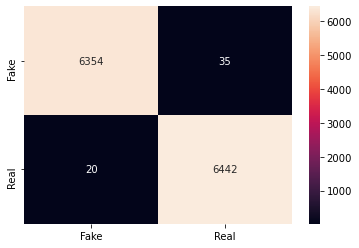

In [32]:
pred = model.predict_classes(X_test)
cf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

In [33]:
# train a 1D convnet with a deep network
model2 = cnn_net2()

batch_size = 256
epochs = 8

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          48723300  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 497, 128)          153728    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               32250     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [ ]:
history = model2.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Train on 29983 samples, validate on 12851 samples
Epoch 1/8
29983/29983 [==============================] - 172s 6ms/step - loss: 0.3446 - accuracy: 0.8281 - val_loss: 0.1088 - val_accuracy: 0.9415
Epoch 2/8
29983/29983 [==============================] - 160s 5ms/step - loss: 0.1088 - accuracy: 0.9402 - val_loss: 0.1385 - val_accuracy: 0.9309
Epoch 3/8
27648/29983 [==========================>...] - ETA: 10s - loss: 0.0962 - accuracy: 0.9440

In [ ]:
accr_train = model2.evaluate(X_train,y_train)
print('Accuracy Train: {}'.format(accr_train[1]*100))
accr_test = model2.evaluate(X_test,y_test)
print('Accuracy Test: {}'.format(accr_test[1]*100))